# Using enterprise_extensions to analyze PTA data

In this notebook you will learn:
* How to use `enterprise_extensions` to create `enterprise` models,
* How to search in PTA data for a isotropic stochastic gravitational wave background using multiple pulsars,
* How to implement a HyperModel object to sample a `model_2a` model,
* How to post-process your results.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

import sys
sys.path.append("..")
from settings import fd_bins

## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print('datadir =', datadir)

datadir = ../../data


In [3]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

## Read par and tim files into `enterprise` `Pulsar` objects


In [4]:
# check for file and load pickle if it exists:
pickle_loc = datadir + '/psrs.pkl'
if os.path.exists(pickle_loc):
    with open(pickle_loc, 'rb') as f:
        psrs = pickle.load(f)

# else: load them in slowly:
else:
    psrs = []
    ephemeris = 'DE438'
    for p, t in zip(parfiles, timfiles):
        psr = Pulsar(p, t, ephem=ephemeris)
        psrs.append(psr)

# Make your own pickle of these loaded objects to reduce load times significantly
# at the cost of some space on your computer (~1.8 GB).
with open(datadir + '/psrs.pkl', 'wb') as f:
    pickle.dump(psrs, f)

In [5]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

### Set up PTA model

* This model_2a includes everything from the verbose version in these tutorials:
    *    fixed white noise parameters based on noisedict `params`,
    *   common red noise signal (no correlation function) with 5 frequencies,
    *   and a spectral index of 13/3

In [6]:
pta = models.model_2a(psrs,
                      psd='powerlaw',
                      noisedict=params,
                      n_gwbfreqs=5,  # modify the number of common red noise frequencies used here
                      gamma_common=13/3)  # remove this line for a varying spectral index

### Setup an instance of a HyperModel.
* This doesn't mean we are doing model selection (yet!), but the
 hypermodel module gives access to some nifty sampling schemes.

In [7]:
super_model = hypermodel.HyperModel({0: pta})

### Setup PTMCMCSampler

In [8]:
outDir = '../../chains/extensions_chains'

sampler = super_model.setup_sampler(resume=True,
                                    outdir=outDir,
                                    sample_nmodel=False,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...



/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
# sampler for N steps
N = int(5e6)
x0 = super_model.initial_sample()

In [17]:
# Sampling this will take a very long time. If you want to sample it yourself, uncomment the next line:
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Resuming run from chain file ../../chains/extensions_chains/chain_1.txt
Adding DE jump with weight 50
Finished 68.88 percent in 137869.570268 s Acceptance rate = 0.472548

### Plot Output

In [10]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']
burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [16]:
ind = list(pta.param_names).index('gw_log10_A')

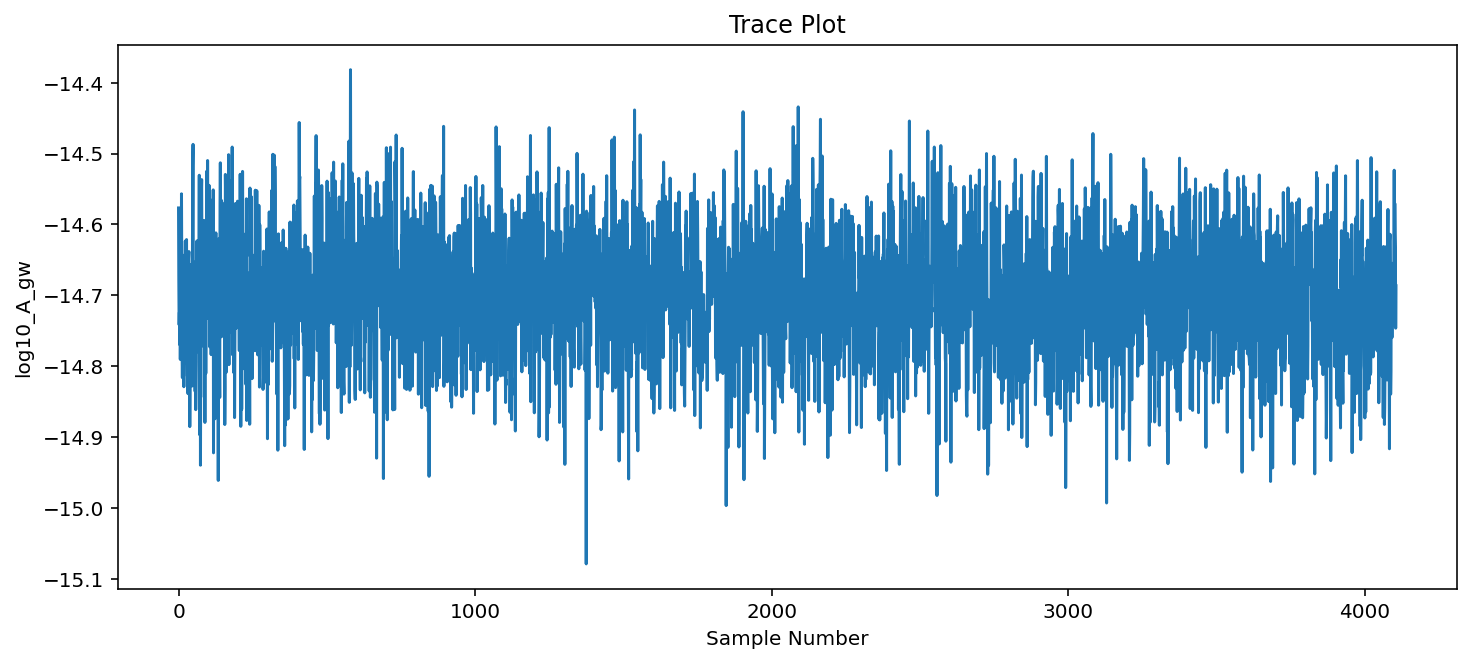

In [17]:
# Make trace-plot to diagnose sampling
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Sample Number')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.show()

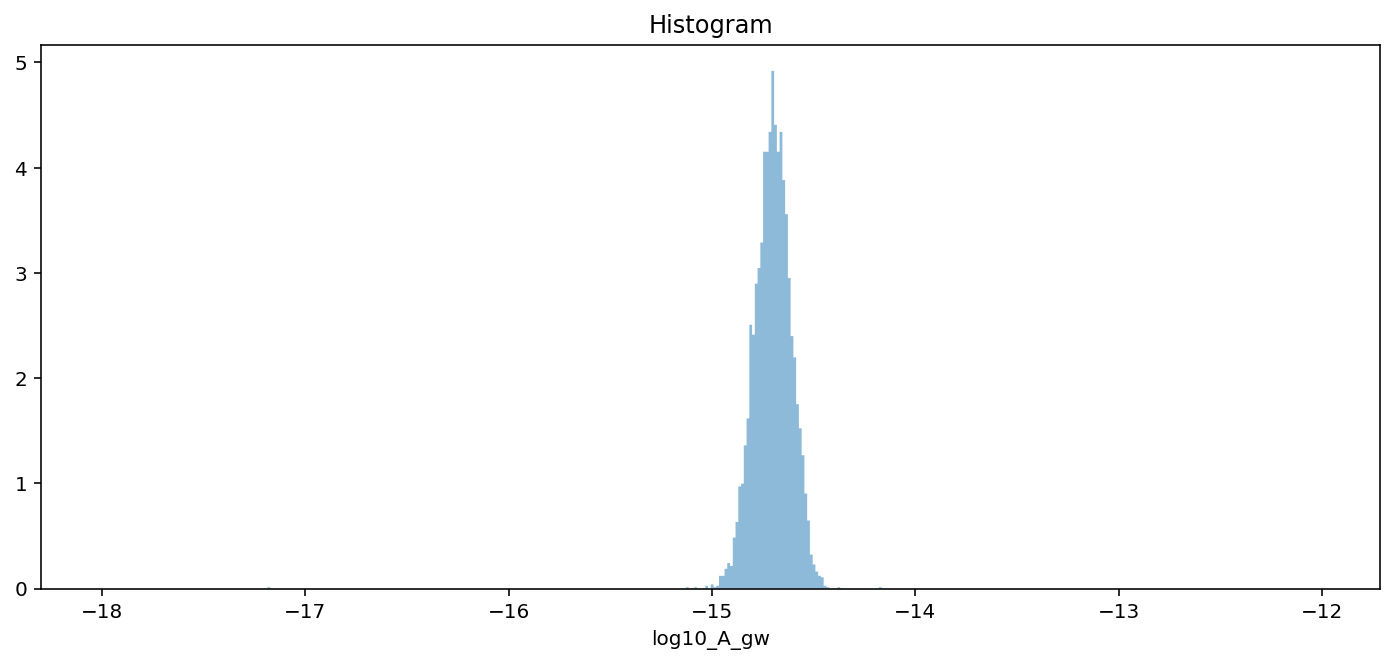

In [18]:
# Plot a histogram of the marginalized posterior distribution
bins = fd_bins(chain[:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[:, ind], bins=bins, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

In [19]:
# Compute maximum posterior value
hist = np.histogram(chain[burn:, pta.param_names.index('gw_log10_A')],
                          bins=bins,
                          density=True)
max_ind = np.argmax(hist[0])
print('our_max =', hist[1][max_ind])  # from our computation

our_max = -14.707808651660155


This analysis is consistent with the verbose version.
Here we have introduced some convenient methods:
* Using a HyperModel object for a single model,
* Using `enterprise_extensions` to create the model,
* Sampling a `HyperModel` with `PTMCMCSampler`.